In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
2017-08-23 00:00:00
2016-08-23 00:00:00
[   0    1    2 ... 2220 2221 2222]
2223
190


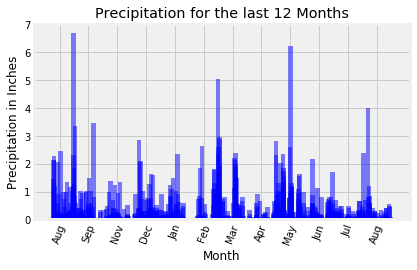

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#get the last entry date
last_entry_date = np.ravel(session.query(Measurement.date).\
    order_by(Measurement.date.desc()).limit(1).all())

current_date= datetime.strptime(last_entry_date[0], '%Y-%m-%d')


# Calculate the date 1 year ago from the last data point in the database
#current_date = dt.datetime(2017, 8, 23)
last_twelve_months = current_date + relativedelta(months=-12)
print(current_date)
print(last_twelve_months)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date > last_twelve_months).order_by(Measurement.date.desc()).all()

prcp = [result[0] for result in results]
prcp_date = [result[1] for result in results]
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['precipitation', 'precipitation_date'])
df = df.set_index('precipitation_date')
df = df.sort_values(by=['precipitation_date'])

# Sort the dataframe by date
df.head(10)
# Use Pandas Plotting with Matplotlib to plot the data
plt.title("Precipitation for the last 12 Months")
plt.xlabel('Month')
plt.ylabel('Precipitation in Inches')
months = ['Aug', 'Sep', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
y = df['precipitation'].tolist()
x = np.arange(0, len(df.index.tolist()), 1)
print(x)
month_total = len(y)
print(month_total)
month_step_xticks = int((month_total / 12) * 1.03)
print(month_step_xticks)
plt.ylim = max(y) + 1
tick_locations = [ x+55 for x in range(1, month_total, month_step_xticks)]
plt.bar(x, y, width=30, color = 'blue', alpha=0.5, align = 'edge')
plt.xticks(tick_locations, months, rotation = 70)
plt.subplots_adjust(bottom=0.2)
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# Design a query to retrieve the 

station_results = session.query(Station.station).distinct(Station.station).count()

print(f"Total number of stations: {station_results}")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
Total number of stations: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#engine.execute("SELECT station , count(station) as station_count FROM measurement GROUP BY station ORDER BY station_count DESC").fetchall()

station_count = session.query(Measurement.station ,func.count(Measurement.station).label("StationCount")).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

station_list = [result for result in station_count]
np.ravel(station_list)
print(station_list)
station_name = [result[0] for result in station_list]
station_count = [result[1] for result in station_list]
most_active_station = station_name[0]
print(most_active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
USC00519281


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute("SELECT min(tobs),max(tobs),avg(tobs) FROM measurement\
    where station == :sta",sta = most_active_station).fetchall()


[(54.0, 85.0, 71.66378066378067)]

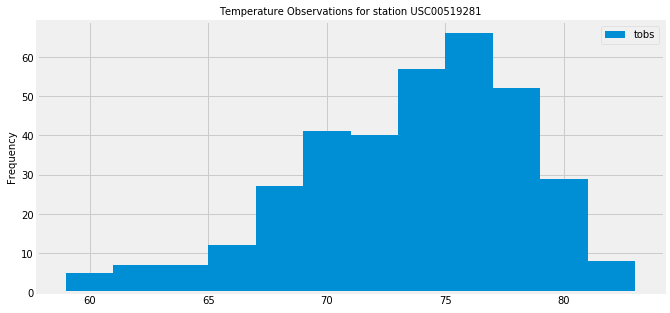

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data_12m = session.query(Measurement.tobs,Measurement.date)\
    .filter(Measurement.date > last_twelve_months, Measurement.station == most_active_station).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(station_data_12m, columns=['tobs', 'precip_date'])
df = df.set_index('precip_date')
 
hist_plot = df['tobs'].hist(bins=12, figsize=(10,5),label = 'tobs') 
hist_plot.set_title(f'Temperature Observations for station {most_active_station}', fontsize=10)
hist_plot.set_ylabel('Frequency', fontsize=10)

hist_plot.legend()
plt.savefig("temphistogram.png")
plt.show()


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2017-08-01', '2017-08-15')
trip_data

[(70.0, 78.8688524590164, 84.0)]

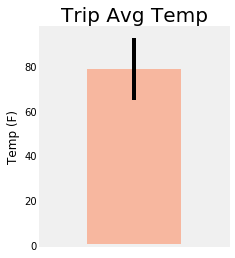

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_df = pd.DataFrame(trip_data, columns=['min_temp', 'avg_temp', 'max_temp'])
avg_temp = avg_df['avg_temp']
min_max_temp = avg_df.iloc[0]['max_temp'] - avg_df.iloc[0]['min_temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(3,4), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_station = engine.execute("SELECT m.station , sum(m.prcp) as prcp_cnt, s.name,s.latitude,s.longitude, s.elevation FROM measurement as m, station as s \
                     WHERE m.station = s.station and m.date between '2017-08-01' and '2017-08-15' \
                     GROUP BY m.station ORDER BY prcp_cnt DESC").fetchall()


rainfall_station

[('USC00516128', 1.7, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.38, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00514830', 0.33, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519523', 0.14, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519397', 0.06, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]